## XG Boost

Hold-out ROC AUC: 0.9146
Hold-out PR  AUC: 0.9187

Classification report:
               precision    recall  f1-score   support

           0      0.813     0.874     0.842     12397
           1      0.846     0.776     0.809     11073

    accuracy                          0.827     23470
   macro avg      0.829     0.825     0.826     23470
weighted avg      0.829     0.827     0.827     23470



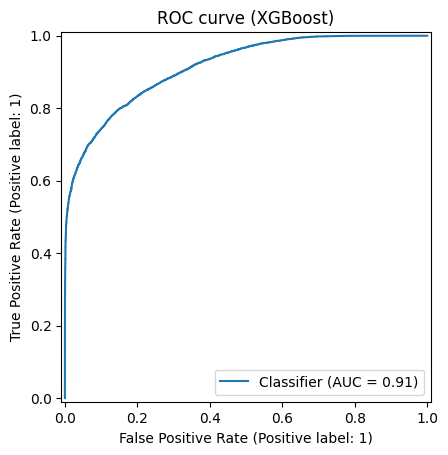

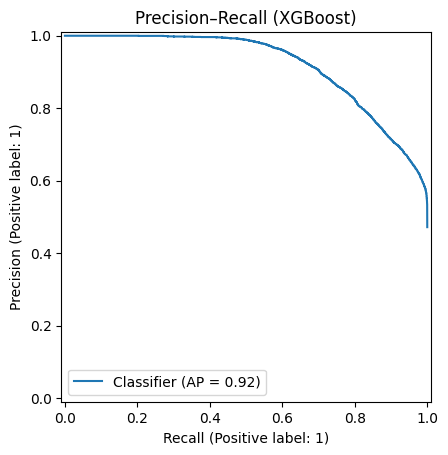


Top 20 features by gain:
                        feature       gain
          age_gender_missing_1 114.659019
          age_gender_missing_0  84.564812
       province_hei long jiang  33.433121
      usr_action_types_taken_5  26.344919
                usr_share_rate  18.725126
          usr_sum_share_follow  17.329607
            province_xin jiang  17.302523
    usr_sum_isLike_x_followlog  16.941826
               usr_action_rate  16.661581
      usr_action_types_taken_4  16.452602
              province_fu jian  15.899797
          usr_max_share_follow  15.696879
 usr_shares_per_exp_follow_max  15.200864
 usr_sum_isComment_x_followlog  14.530343
             province_jiang xi  14.425992
            province_shan dong  14.100012
usr_shares_per_exp_follow_mean  13.966199
              province_wei zhi  13.921254
                 usr_like_rate  13.824567
        usr_mean_followCnt_log  13.808367


In [11]:
# XGBoost on ../data/cleaned_data.csv (fixed early stopping without leakage)
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report
)
from xgboost import XGBClassifier

# -------------------------
# Load & target
# -------------------------
df = pd.read_csv(Path("../data/cleaned_data.csv"))
y = df["y_active"].astype(int)

drop_cols = [c for c in ["y_active","mlogId","userId","creatorId","contentId","talkId"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")

# -------------------------
# Splits
# -------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

# -------------------------
# Column typing
# -------------------------
cat_cols = list(X_train.select_dtypes(include=["object","category","string","bool"]).columns)
for c in X_train.select_dtypes(include=["int16","int32","int64","Int8","Int16","Int32","Int64","uint8","uint16"]).columns:
    if X_train[c].nunique(dropna=True) <= 20 and c not in cat_cols:
        cat_cols.append(c)
num_cols = [c for c in X_train.columns if c not in cat_cols]

# -------------------------
# Preprocessor (fit on train only)
# -------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)

# Fit on TRAIN, transform all splits
X_train_t = pre.fit_transform(X_train, y_train)
X_valid_t = pre.transform(X_valid)
X_test_t  = pre.transform(X_test)

# Feature names after OH
oh = pre.named_transformers_["cat"].named_steps["oh"] if len(cat_cols) else None
cat_names = oh.get_feature_names_out(cat_cols) if oh is not None else np.array([])
num_names = np.array(num_cols)
feature_names = np.r_[num_names, cat_names]

# -------------------------
# Model (class imbalance aware)
# -------------------------
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / max(pos, 1))
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Convert to DMatrix (XGBoost’s native data structure)
dtrain = xgb.DMatrix(X_train_t, label=y_train)
dvalid = xgb.DMatrix(X_valid_t, label=y_valid)
dtest  = xgb.DMatrix(X_test_t,  label=y_test)

# Parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.03,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "min_child_weight": 1.0,
    "tree_method": "hist",
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
}

# --- Train with early stopping (no sklearn wrapper) ---
evals = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=False,
)

# --- Evaluate on test set ---
proba = booster.predict(dtest)
pred  = (proba >= 0.5).astype(int)

print("Hold-out ROC AUC:", round(roc_auc_score(y_test, proba), 4))
print("Hold-out PR  AUC:", round(average_precision_score(y_test, proba), 4))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC curve (XGBoost)"); plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision–Recall (XGBoost)"); plt.show()

# -------------------------
# Top features (gain)
# -------------------------
# Use the Booster returned by xgb.train(...) (stored in variable `booster`)
# xgb.get_booster() does not exist on the top-level xgboost module.
score = booster.get_score(importance_type="gain")
imp = pd.DataFrame({
    "feature": [feature_names[int(k[1:])] if k.startswith("f") else k for k in score.keys()],
    "gain": list(score.values())
}).sort_values("gain", ascending=False)

print("\nTop 20 features by gain:\n", imp.head(20).to_string(index=False))
